In [1]:
import os
import glob
import yaml #pip install pandas pyyaml
import pandas as pd
import mysql.connector #pip install mysql-connector-python
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Folder path                       
folder_path = r"D:\PROJECTS\Project_2\Data-Driven-Stock-Analysis\data"

# Month folders
month_name = [
    "2023-10","2023-11","2023-12","2024-01","2024-02","2024-03",
    "2024-04","2024-05","2024-06","2024-07","2024-08","2024-09","2024-10","2024-11"
]

# List to store all YAML data
records = []

# Loop through all month subfolders
for month in month_name:
    folder = os.path.join(folder_path, month)
    yaml_files = glob.glob(os.path.join(folder, "*.yaml"))

    for file_path in yaml_files:
        with open(file_path, "r") as file:
            data = yaml.safe_load(file)
            if data:
                # Append depending on type
                if isinstance(data, dict):
                    records.append(data)
                elif isinstance(data, list):
                    records.extend(data)
        print(f"Loaded {os.path.basename(file_path)} from {month}")


Loaded 2023-10-03_05-30-00.yaml from 2023-10
Loaded 2023-10-04_05-30-00.yaml from 2023-10
Loaded 2023-10-05_05-30-00.yaml from 2023-10
Loaded 2023-10-06_05-30-00.yaml from 2023-10
Loaded 2023-10-09_05-30-00.yaml from 2023-10
Loaded 2023-10-10_05-30-00.yaml from 2023-10
Loaded 2023-10-11_05-30-00.yaml from 2023-10
Loaded 2023-10-12_05-30-00.yaml from 2023-10
Loaded 2023-10-13_05-30-00.yaml from 2023-10
Loaded 2023-10-16_05-30-00.yaml from 2023-10
Loaded 2023-10-17_05-30-00.yaml from 2023-10
Loaded 2023-10-18_05-30-00.yaml from 2023-10
Loaded 2023-10-19_05-30-00.yaml from 2023-10
Loaded 2023-10-20_05-30-00.yaml from 2023-10
Loaded 2023-10-23_05-30-00.yaml from 2023-10
Loaded 2023-10-25_05-30-00.yaml from 2023-10
Loaded 2023-10-26_05-30-00.yaml from 2023-10
Loaded 2023-10-27_05-30-00.yaml from 2023-10
Loaded 2023-10-30_05-30-00.yaml from 2023-10
Loaded 2023-10-31_05-30-00.yaml from 2023-10
Loaded 2023-11-01_05-30-00.yaml from 2023-11
Loaded 2023-11-02_05-30-00.yaml from 2023-11
Loaded 202

In [26]:
# Convert all to one DataFrame
df1= pd.DataFrame(records)

print(f"\nTotal records loaded: {len(df1)}")
print(df1.head())



Total records loaded: 14200
       Ticker    close                 date    high      low    month    open  \
0        SBIN   602.95  2023-10-03 05:30:00   604.9   589.60  2023-10   596.6   
1  BAJFINANCE  7967.60  2023-10-03 05:30:00  7975.5  7755.00  2023-10  7780.8   
2       TITAN  3196.25  2023-10-03 05:30:00  3212.5  3114.40  2023-10  3148.8   
3         ITC   439.75  2023-10-03 05:30:00   442.9   439.25  2023-10   441.0   
4         TCS  3513.85  2023-10-03 05:30:00  3534.2  3480.10  2023-10  3534.2   

     volume  
0  15322196  
1    944555  
2   1007308  
3   7481883  
4   1948148  


In [30]:
df1['Ticker'].unique()

array(['SBIN', 'BAJFINANCE', 'TITAN', 'ITC', 'TCS', 'LT', 'TATACONSUM',
       'RELIANCE', 'HCLTECH', 'JSWSTEEL', 'ULTRACEMCO', 'POWERGRID',
       'INFY', 'TRENT', 'BHARTIARTL', 'TATAMOTORS', 'WIPRO', 'TECHM',
       'NTPC', 'HINDUNILVR', 'APOLLOHOSP', 'M&M', 'GRASIM', 'ICICIBANK',
       'ADANIENT', 'ADANIPORTS', 'BEL', 'BAJAJFINSV', 'EICHERMOT',
       'COALINDIA', 'MARUTI', 'INDUSINDBK', 'ASIANPAINT', 'TATASTEEL',
       'HDFCLIFE', 'DRREDDY', 'SUNPHARMA', 'KOTAKBANK', 'SHRIRAMFIN',
       'NESTLEIND', 'ONGC', 'CIPLA', 'BPCL', 'BRITANNIA', 'SBILIFE',
       'HINDALCO', 'HEROMOTOCO', 'AXISBANK', 'HDFCBANK', 'BAJAJ-AUTO'],
      dtype=object)

In [6]:
def get_connection():
    return mysql.connector.connect(
        host="localhost",
        user="root",
        password="0007"
    )

In [7]:
# Establish connection
conn = get_connection()

# Create a cursor
cursor = conn.cursor()

# Create database
cursor.execute("CREATE DATABASE DATA")
print("Database 'DATA' created successfully!")

# Close connection
cursor.close()
conn.close()


Database 'DATA' created successfully!


In [8]:
# Connect to MySQL
conn = get_connection()
cursor = conn.cursor()
cursor.execute("USE DATA")

# Create table
cursor.execute("""
    CREATE TABLE IF NOT EXISTS MARKET (
        Ticker VARCHAR(50),
        close DECIMAL(10,2),
        date DATETIME,
        high DECIMAL(10,2),
        low DECIMAL(10,2),
        month VARCHAR(10),
        open DECIMAL(10,2),
        volume INT
    )
""")

# Commit and close
conn.commit()
cursor.close()
conn.close()

print("Table 'MARKET' created successfully!")

Table 'MARKET' created successfully!


In [ ]:
conn = get_connection()
cursor = conn.cursor()
cursor.execute("USE DATA")
# Loop through DataFrame rows
for _, row in df1.iterrows():
    cursor.execute("""
        INSERT INTO MARKET (Ticker, close, date, high, low, month,open,volume)
        VALUES (%s, %s, %s, %s, %s,%s, %s,%s)
    """, (
        row.get("Ticker"),
        row.get("close"),
        row.get("date"),
        row.get("high"),
        row.get("low"),
        row.get("month"),
        row.get("open"),
        row.get("volume")
    ))

# Commit changes and close connection
conn.commit()
cursor.close()
conn.close()

print("Data inserted successfully into 'MARKET'!")


Data inserted successfully into 'MARKET'!


Table ' Volatility_Analysis' created successfully!


In [7]:
# Folder to save CSV files
output_folder =os.path.join(folder_path,"output_csv") #r"D:\data_driven\output_csv"
os.makedirs(output_folder, exist_ok=True)
conn = get_connection()
cursor = conn.cursor()
cursor.execute("USE DATA")

# Step 1: Get distinct tickers
cursor.execute("SELECT DISTINCT Ticker FROM MARKET")
companies = [row[0] for row in cursor.fetchall()]  # flatten to list
print("Tickers found:", companies)

# Step 2: Loop through each ticker, fetch data, and save as CSV
for ticker in companies:
    print(f"Processing {ticker}...")

    cursor.execute("""
        SELECT Ticker, close, date, high, low, month, open,volume
        FROM MARKET
        WHERE Ticker = %s
    """, (ticker,))
    rows = cursor.fetchall()

    # Convert to DataFrame
    df = pd.DataFrame(rows, columns=["Ticker", "close", "date", "high", "low", "month", "open","volume"])

    # Step 3: Save to CSV
    csv_path = os.path.join(output_folder, f"{ticker}.csv")
    df.to_csv(csv_path, index=False)

    print(f"Saved: {csv_path}")

# Close connection
cursor.close()
conn.close()

print("✅ All ticker data exported to CSV successfully!")


Tickers found: ['SBIN', 'BAJFINANCE', 'TITAN', 'ITC', 'TCS', 'LT', 'TATACONSUM', 'RELIANCE', 'HCLTECH', 'JSWSTEEL', 'ULTRACEMCO', 'POWERGRID', 'INFY', 'TRENT', 'BHARTIARTL', 'TATAMOTORS', 'WIPRO', 'TECHM', 'NTPC', 'HINDUNILVR', 'APOLLOHOSP', 'M&M', 'GRASIM', 'ICICIBANK', 'ADANIENT', 'ADANIPORTS', 'BEL', 'BAJAJFINSV', 'EICHERMOT', 'COALINDIA', 'MARUTI', 'INDUSINDBK', 'ASIANPAINT', 'TATASTEEL', 'HDFCLIFE', 'DRREDDY', 'SUNPHARMA', 'KOTAKBANK', 'SHRIRAMFIN', 'NESTLEIND', 'ONGC', 'CIPLA', 'BPCL', 'BRITANNIA', 'SBILIFE', 'HINDALCO', 'HEROMOTOCO', 'AXISBANK', 'HDFCBANK', 'BAJAJ-AUTO']
Processing SBIN...
Saved: D:\PROJECTS\Project_2\Data-Driven-Stock-Analysis\data\output_csv\SBIN.csv
Processing BAJFINANCE...
Saved: D:\PROJECTS\Project_2\Data-Driven-Stock-Analysis\data\output_csv\BAJFINANCE.csv
Processing TITAN...
Saved: D:\PROJECTS\Project_2\Data-Driven-Stock-Analysis\data\output_csv\TITAN.csv
Processing ITC...
Saved: D:\PROJECTS\Project_2\Data-Driven-Stock-Analysis\data\output_csv\ITC.csv
Pro

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [9]:
output_folder = os.path.join(folder_path, "output_csv")
all_files = glob.glob(os.path.join(output_folder, "*.csv"))

list_val=[]
DATE_COL = 'date'
CLOSE_COL = 'close'

for filename in all_files:
    df2 = pd.read_csv(filename)
    ticker = os.path.splitext(os.path.basename(filename))[0].upper()
    df_cleaned = df2[[DATE_COL, CLOSE_COL]].copy()
    df_cleaned.rename(columns={DATE_COL: 'Date', CLOSE_COL: 'Close'}, inplace=True)
    df_cleaned['Ticker'] = ticker
    list_val.append(df_cleaned)

combined_df = pd.concat(list_val, axis=0, ignore_index=True)
combined_df.to_csv("combined_stock_data.csv", index=False)


In [10]:
list_val

[                    Date    Close    Ticker
 0    2023-10-03 05:30:00  2387.25  ADANIENT
 1    2023-10-04 05:30:00  2464.95  ADANIENT
 2    2023-10-05 05:30:00  2466.35  ADANIENT
 3    2023-10-06 05:30:00  2478.10  ADANIENT
 4    2023-10-09 05:30:00  2442.60  ADANIENT
 ..                   ...      ...       ...
 279  2024-11-14 05:30:00  2826.80  ADANIENT
 280  2024-11-18 05:30:00  2818.70  ADANIENT
 281  2024-11-19 05:30:00  2821.50  ADANIENT
 282  2024-11-21 05:30:00  2183.65  ADANIENT
 283  2024-11-22 05:30:00  2228.00  ADANIENT
 
 [284 rows x 3 columns],
                     Date    Close      Ticker
 0    2023-10-03 05:30:00   831.40  ADANIPORTS
 1    2023-10-04 05:30:00   824.60  ADANIPORTS
 2    2023-10-05 05:30:00   825.20  ADANIPORTS
 3    2023-10-06 05:30:00   830.75  ADANIPORTS
 4    2023-10-09 05:30:00   790.05  ADANIPORTS
 ..                   ...      ...         ...
 279  2024-11-14 05:30:00  1264.55  ADANIPORTS
 280  2024-11-18 05:30:00  1279.30  ADANIPORTS
 281  2024

In [11]:
combined_df

,Date,Close,Ticker
0,2023-10-03 05:30:00,2387.25,ADANIENT
1,2023-10-04 05:30:00,2464.95,ADANIENT
2,2023-10-05 05:30:00,2466.35,ADANIENT
3,2023-10-06 05:30:00,2478.10,ADANIENT
4,2023-10-09 05:30:00,2442.60,ADANIENT
...,...,...,...
14195,2024-11-14 05:30:00,566.70,WIPRO
14196,2024-11-18 05:30:00,552.85,WIPRO
14197,2024-11-19 05:30:00,562.00,WIPRO
14198,2024-11-21 05:30:00,557.15,WIPRO


Data inserted successfully into 'Volatility_Analysis'!


In [16]:
v=combined_df['Ticker'].unique()
len(v)

50

In [17]:
combined_df['Date'] = pd.to_datetime(combined_df['Date'])
combined_df['Close'] = pd.to_numeric(combined_df['Close'], errors='coerce')

In [18]:

combined_df['Date'] = pd.to_datetime(combined_df['Date'])
combined_df['Close'] = pd.to_numeric(combined_df['Close'], errors='coerce')
combined_df = combined_df.dropna(subset=['Close'])
combined_df = combined_df.sort_values(by=['Ticker', 'Date'])

combined_df['Daily_Return'] = combined_df.groupby('Ticker')['Close'].pct_change()
returns_df = combined_df.dropna(subset=['Daily_Return'])
volatility = returns_df.groupby('Ticker')['Daily_Return'].std().reset_index()
volatility.columns = ['Ticker', 'Volatility']
top_10_volatility = volatility.sort_values(by='Volatility', ascending=False).head(10)

In [19]:
top_10_volatility

,Ticker,Volatility
0,ADANIENT,0.028601
1,ADANIPORTS,0.026029
8,BEL,0.023283
47,TRENT,0.023074
34,ONGC,0.022247
10,BPCL,0.022069
39,SHRIRAMFIN,0.021687
13,COALINDIA,0.021411
21,HINDALCO,0.019587
33,NTPC,0.019475


In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(top_10_volatility['Ticker'], top_10_volatility['Volatility'], color='teal')
plt.xlabel('Stock Ticker')
plt.ylabel('Volatility (Standard Deviation of Daily Returns)')
plt.title('Top 10 Most Volatile Stocks')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('top_10_volatility_bar_chart.png')


Top 5 Stocks Based on Cumulative Return:
47         TRENT
8            BEL
30           M&M
5     BAJAJ-AUTO
9     BHARTIARTL
Name: Ticker, dtype: object


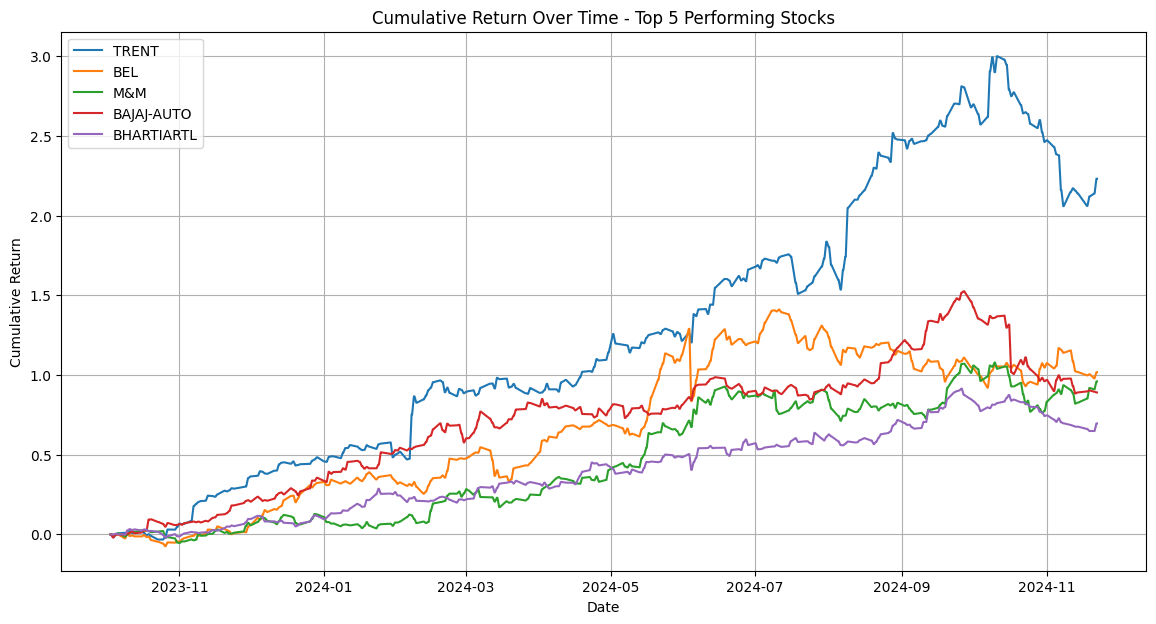

In [4]:


# --- READ COMBINED CSV FILES ---
output_folder = os.path.join(folder_path, "output_csv")
all_files = glob.glob(os.path.join(output_folder, "*.csv"))

list_val = []
DATE_COL = 'date'
CLOSE_COL = 'close'

for filename in all_files:
    df2 = pd.read_csv(filename)
    ticker = os.path.splitext(os.path.basename(filename))[0].upper()

    df_cum = df2[[DATE_COL, CLOSE_COL]].copy()
    df_cum.rename(columns={DATE_COL: 'Date', CLOSE_COL: 'Close'}, inplace=True)
    df_cum['Ticker'] = ticker

    list_val.append(df_cum)

cum_df = pd.concat(list_val, axis=0, ignore_index=True)

# Sort by date (important!)
cum_df['Date'] = pd.to_datetime(cum_df['Date'])
cum_df.sort_values(by=['Ticker', 'Date'], inplace=True)

# Calculate cumulative return
cum_df['Start_Close'] = cum_df.groupby("Ticker")['Close'].transform('first')
cum_df['Cumulative_Return'] = (cum_df['Close'] / cum_df['Start_Close']) - 1
cum_df['Cumulative_Return_Percent'] = cum_df['Cumulative_Return'] * 100

# ------------- SELECT TOP 5 STOCKS -----------------

# Get last cumulative return value per stock
final_cum = cum_df.groupby("Ticker")['Cumulative_Return'].last().reset_index()

# Pick top 5 performing stocks
top5_tickers = final_cum.sort_values(by='Cumulative_Return', ascending=False).head(5)['Ticker']
print("Top 5 Stocks Based on Cumulative Return:")
print(top5_tickers)

# Filter data for only these 5 stocks
top5_df = cum_df[cum_df['Ticker'].isin(top5_tickers)]

# ------------- PLOT CUMULATIVE RETURNS --------------

plt.figure(figsize=(14, 7))

for ticker in top5_tickers:
    df_plot = top5_df[top5_df['Ticker'] == ticker]
    plt.plot(df_plot['Date'], df_plot['Cumulative_Return'], label=ticker)

plt.title("Cumulative Return Over Time - Top 5 Performing Stocks")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()


In [5]:
top5_df

,Date,Close,Ticker,Start_Close,Cumulative_Return,Cumulative_Return_Percent
2840,2023-10-03 00:00:00,5016.45,BAJAJ-AUTO,5016.45,0.000000,0.000000
2841,2023-10-03 05:30:00,5016.45,BAJAJ-AUTO,5016.45,0.000000,0.000000
2842,2023-10-04 00:00:00,4918.60,BAJAJ-AUTO,5016.45,-0.019506,-1.950583
2843,2023-10-04 05:30:00,4918.60,BAJAJ-AUTO,5016.45,-0.019506,-1.950583
2844,2023-10-05 00:00:00,5011.05,BAJAJ-AUTO,5016.45,-0.001076,-0.107646
...,...,...,...,...,...,...
27259,2024-11-19 05:30:00,6423.85,TRENT,2059.10,2.119737,211.973678
27260,2024-11-21 00:00:00,6460.45,TRENT,2059.10,2.137512,213.751153
27261,2024-11-21 05:30:00,6460.45,TRENT,2059.10,2.137512,213.751153
27262,2024-11-22 00:00:00,6652.80,TRENT,2059.10,2.230926,223.092613


In [ ]:

# ----------------------------
# 1. Load sector mapping
# ----------------------------
sector_map = pd.read_csv(r"D:\PROJECTS\Project_2\Data-Driven-Stock-Analysis\Sector_data - Sheet1.csv")  # stock, sector

# ----------------------------
# 2. Load combined stock price dataset
# ----------------------------
output_folder = os.path.join(folder_path, "output_csv")
all_files = glob.glob(os.path.join(output_folder, "*.csv"))

sect_tick=[]
all_daa=[]
for filename in all_files:
    df2 = pd.read_csv(filename)
    ticker = os.path.splitext(os.path.basename(filename))[0].upper()
    df_cleaned = df2.copy()
    all_daa.append(df_cleaned)
    sect_tick.append(ticker)

combined_df = pd.concat(all_daa, axis=0, ignore_index=True)
combined_df.to_csv("sector_ticker.csv", index=False)  # date, stock, close
combined_df['date'] = pd.to_datetime(combined_df['date'])

n=pd.DataFrame(sect_tick,columns=["Ticker"])
sector_map["COMPANY"]=n["Ticker"].unique()
sector_map.rename(columns={"COMPANY":"Ticker"},inplace=True)
# ----------------------------
# 3. Calculate yearly return for each stock
# ----------------------------
# Get first and last price for each stock
first_last = combined_df.sort_values('date').groupby('Ticker').agg(
    first_price=('close', 'first'),
    last_price=('close', 'last')
)

first_last['yearly_return'] = (first_last['last_price'] - first_last['first_price']) / first_last['first_price'] * 100
first_last.reset_index(inplace=True)

# ----------------------------
# 4. Merge sector data
# ----------------------------
merged = pd.merge(first_last, sector_map, on='Ticker', how='left')

# ----------------------------
# 5. Calculate average yearly return by sector
# ----------------------------
sector_perf = merged.groupby('sector')['yearly_return'].mean().sort_values(ascending=False)

print("\nAverage Sector-wise Returns:")
print(sector_perf)

# ----------------------------
# 6. Plot bar chart
# ----------------------------
plt.figure(figsize=(12,6))
sector_perf.plot(kind='bar')

plt.title("Average Yearly Return by Sector")
plt.xlabel("Sector")
plt.ylabel("Average Yearly Return (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show() 

In [26]:
merged

,Ticker,first_price,last_price,yearly_return,sector,Symbol
0,ADANIENT,2387.25,2228.00,-6.670856,MISCELLANEOUS,ADANI ENTERPRISES: ADANIGREEN
1,ADANIPORTS,831.40,1136.75,36.727207,MISCELLANEOUS,ADANI PORTS & SEZ: ADANIPORTS
2,APOLLOHOSP,5118.95,6935.10,35.478956,MISCELLANEOUS,APOLLO HOSPITALS: APOLLOHOSP
3,ASIANPAINT,3166.85,2472.20,-21.935046,PAINTS,ASIAN PAINTS: ASIANPAINT
4,AXISBANK,1041.05,1142.40,9.735363,BANKING,AXIS BANK: AXISBANK
5,BAJAJ-AUTO,5016.45,9481.65,89.011153,AUTOMOBILES,BAJAJ AUTO: BAJAJ-AUTO
6,BAJAJFINSV,1561.05,1600.85,2.549566,FINANCE,BAJAJ FINANCE: BAJFINANCE
7,BAJFINANCE,7967.60,6683.95,-16.110874,FINANCE,BAJAJ FINSERV: BAJAJFINSV
8,BEL,139.20,280.85,101.760057,DEFENCE,BHARAT ELECTRONICS: BEL
9,BHARTIARTL,925.30,1569.30,69.599049,TELECOM,BHARTI AIRTEL: AIRTEL


In [31]:
# --- READ ALL STOCK CSV FILES ---
def stock_correlation(folder_path):
    output_folder = os.path.join(folder_path, "output_csv")
    all_files = glob.glob(os.path.join(output_folder, "*.csv"))

    stock_dict = {}   # Ticker → its closing prices

    for filename in all_files:
        df = pd.read_csv(filename)
        
        # Extract ticker name from filename
        ticker = os.path.splitext(os.path.basename(filename))[0].upper()

        # Clean dataframe: convert date & sort
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date')

        # Set date as index
        df = df.set_index('date')

        # Keep only the Close column
        stock_dict[ticker] = df['close']

    # Combine all stocks into a single DataFrame by date
    combined_df = pd.DataFrame(stock_dict)

    # Compute correlation matrix
    corr_matrix = combined_df.corr()

    print("\n🔍 STOCK PRICE CORRELATION MATRIX:")
    print(corr_matrix)

    # ---------------- PLOT HEATMAP -------------------
    plt.figure(figsize=(12, 8))
    plt.imshow(corr_matrix, cmap="coolwarm", interpolation="nearest")
    plt.colorbar(label="Correlation Coefficient")

    # Add ticks and labels
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)

    plt.title("Stock Price Correlation Heatmap")
    plt.tight_layout()
    plt.show()

    return corr_matrix


In [ ]:
output_folder = os.path.join(folder_path, "output_csv")
all_files = glob.glob(os.path.join(output_folder, "*.csv"))

all_daa=[]
for filename in all_files:
    df2 = pd.read_csv(filename)
    df_cleaned = df2.copy()
    all_daa.append(df_cleaned)
combined_df = pd.concat(all_daa, axis=0, ignore_index=True)


In [ ]:
all_data = []

    # Read all CSV files and combine
for file in all_files:
    ticker = os.path.splitext(os.path.basename(file))[0].upper()
    df = pd.read_csv(file)

    df['date'] = pd.to_datetime(df['date'])
    df['Ticker'] = ticker
    all_data.append(df)

combined_df = pd.concat(all_data, ignore_index=True)


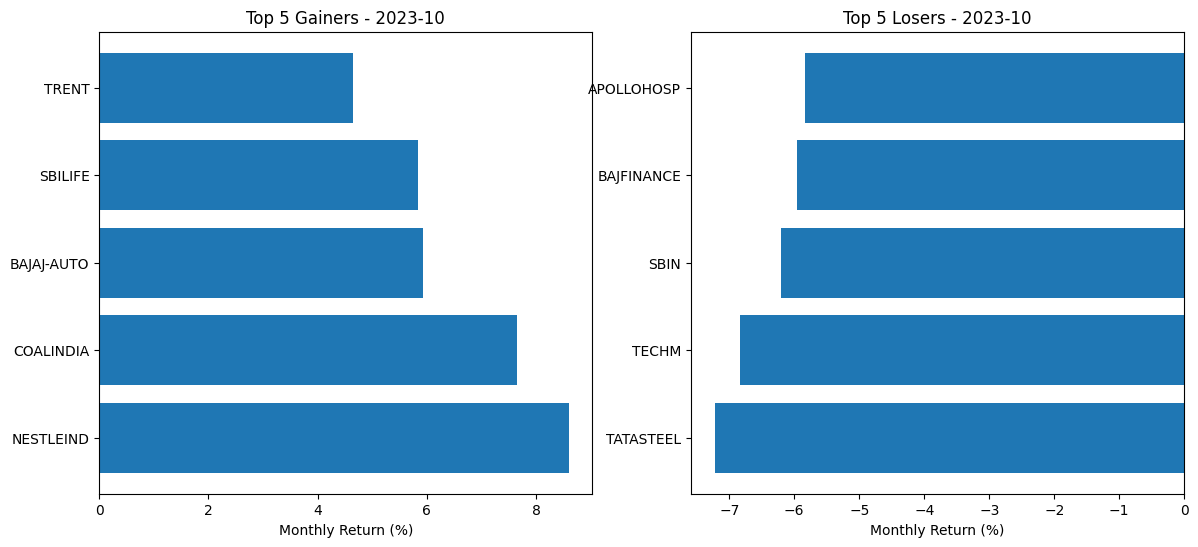

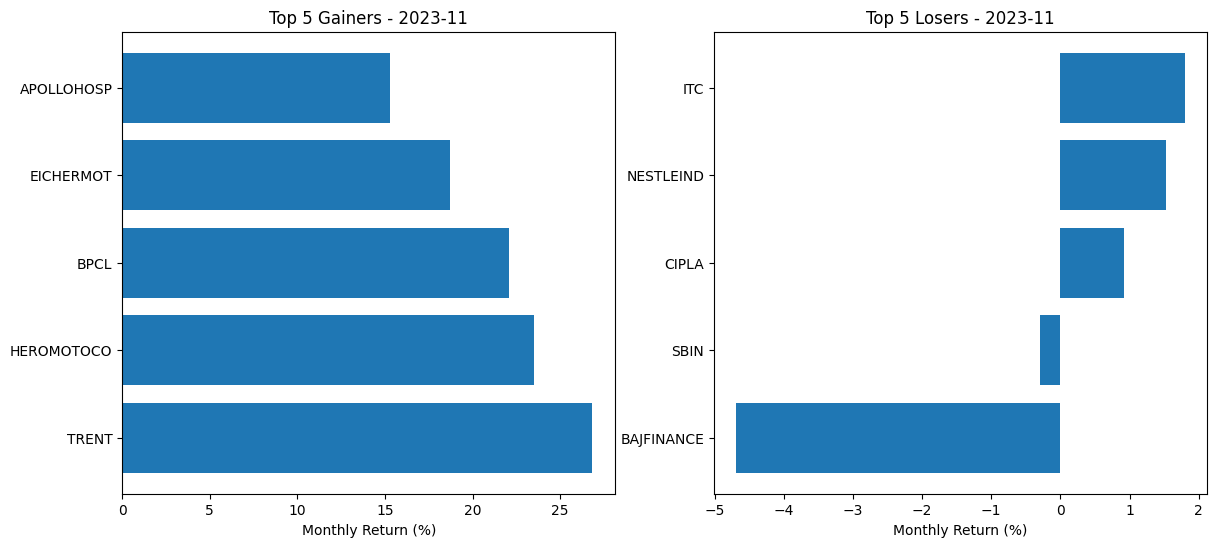

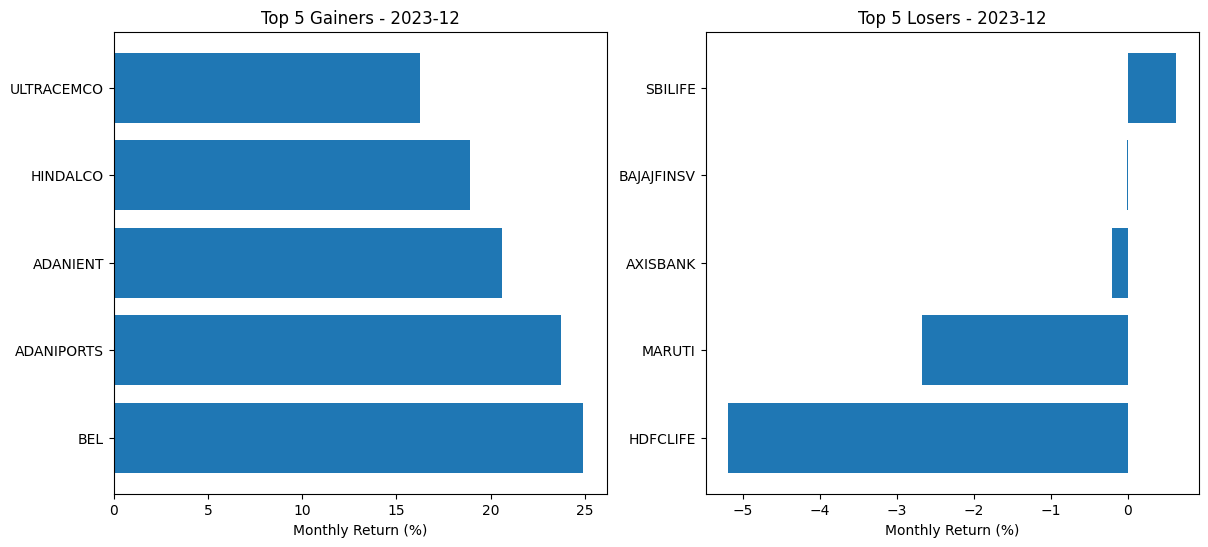

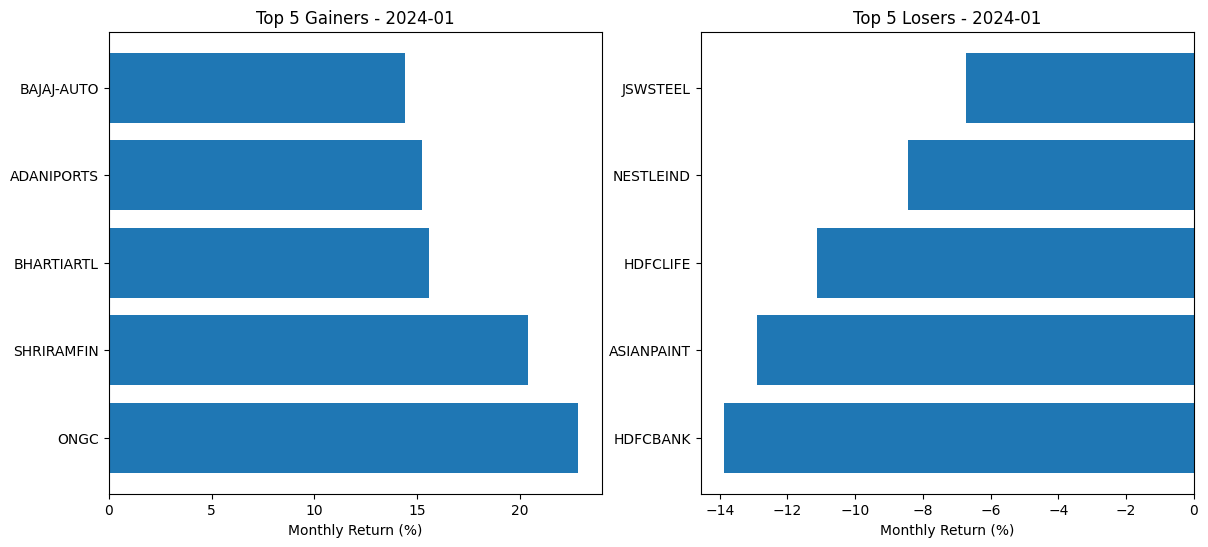

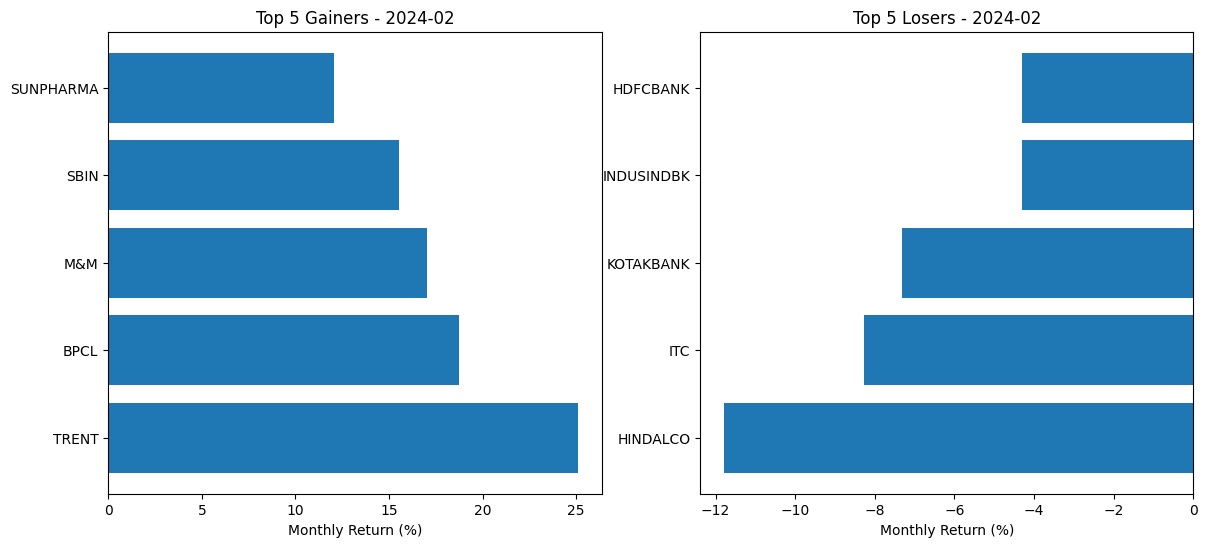

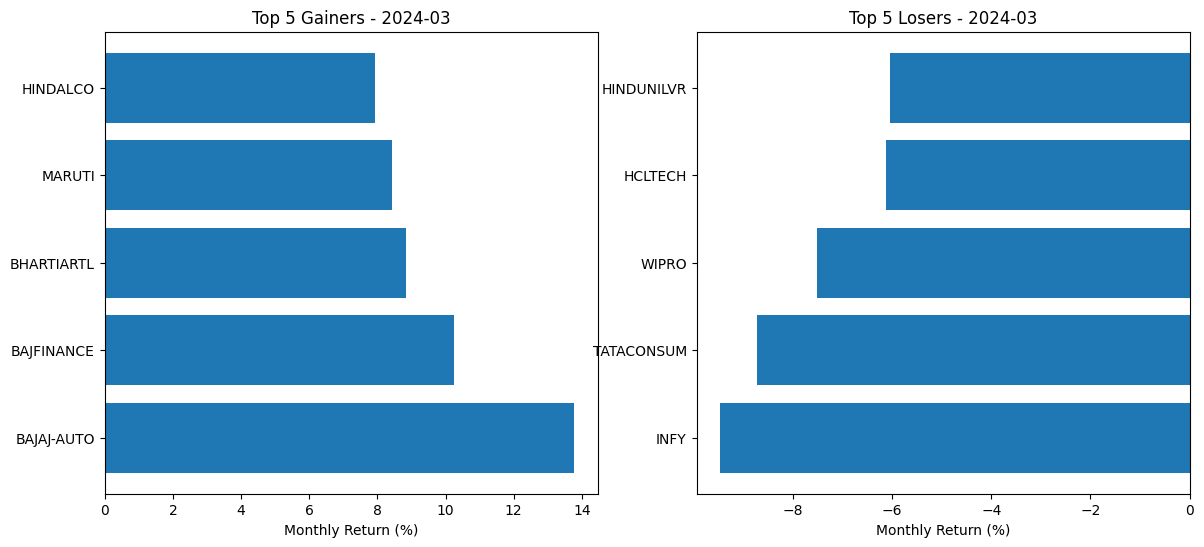

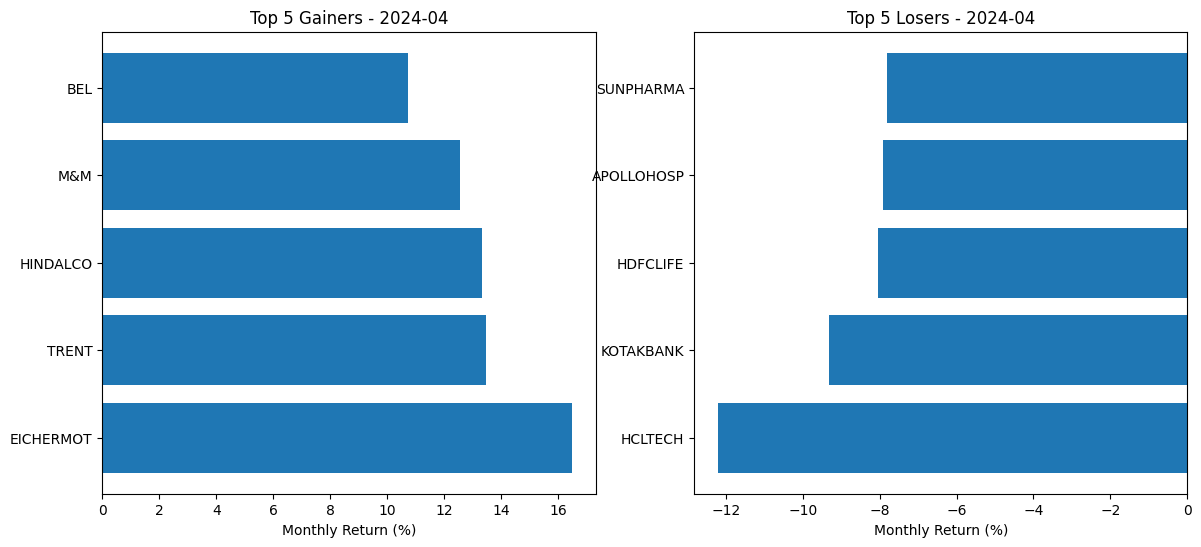

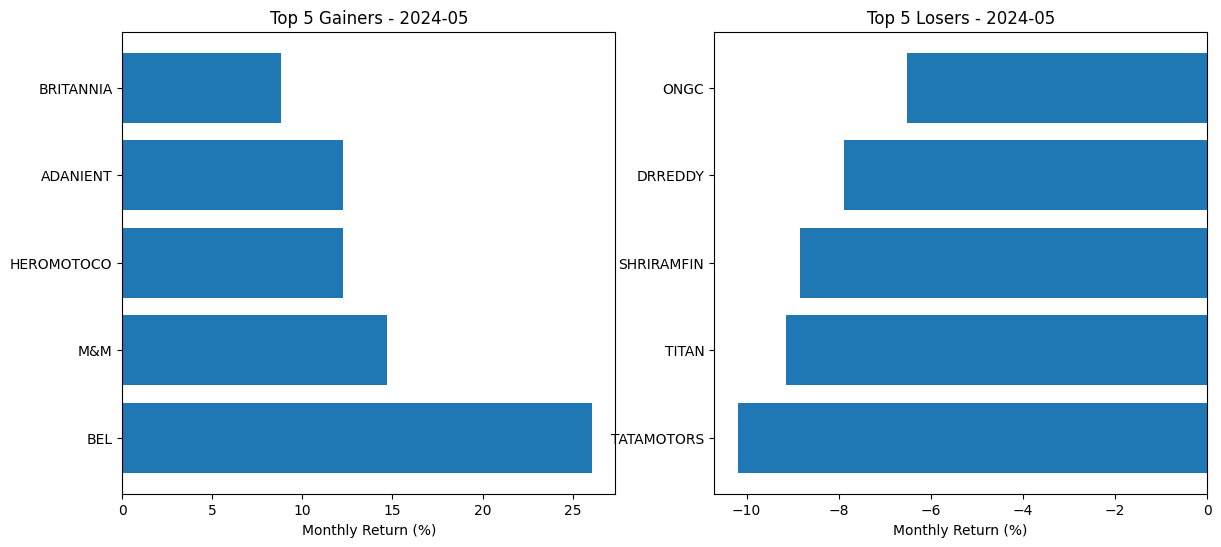

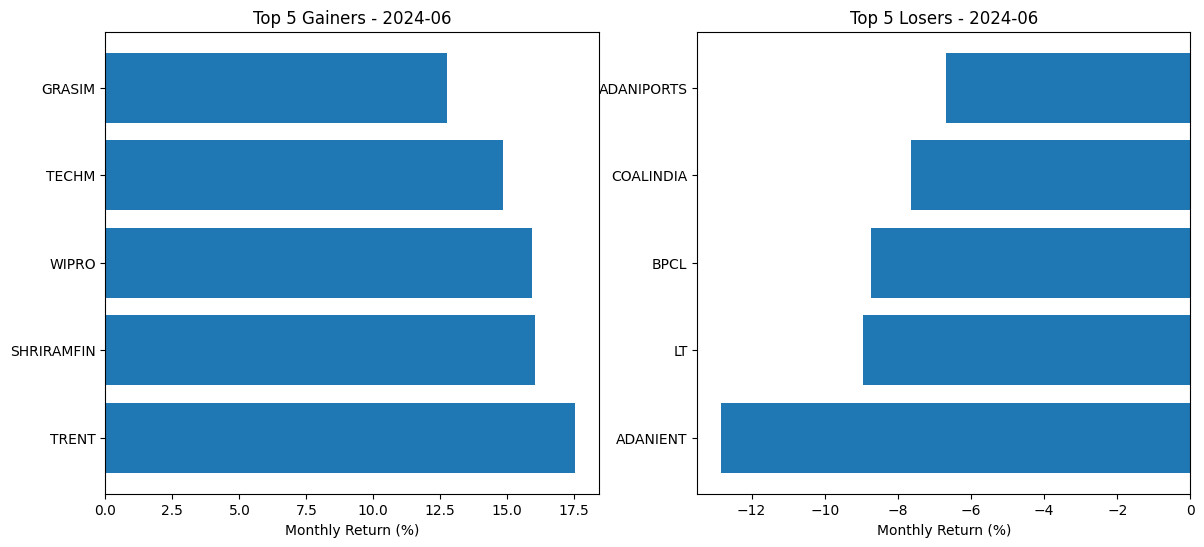

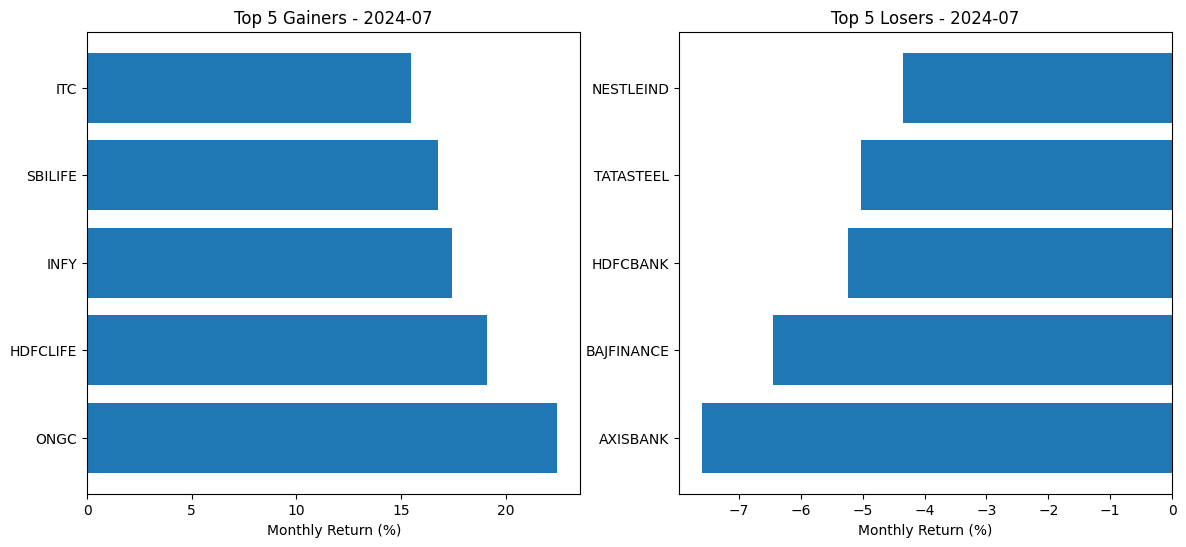

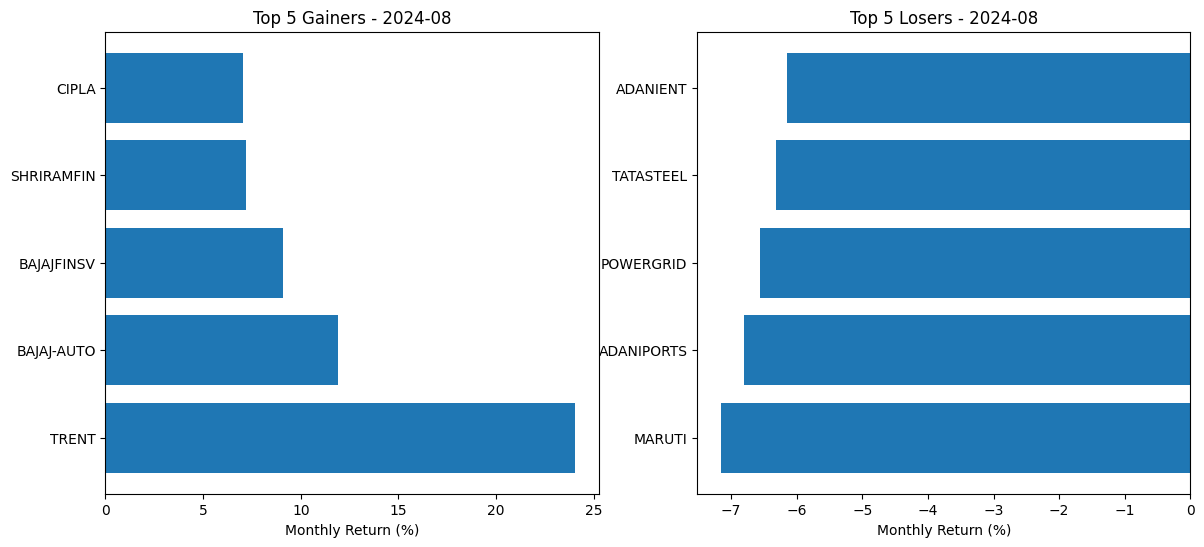

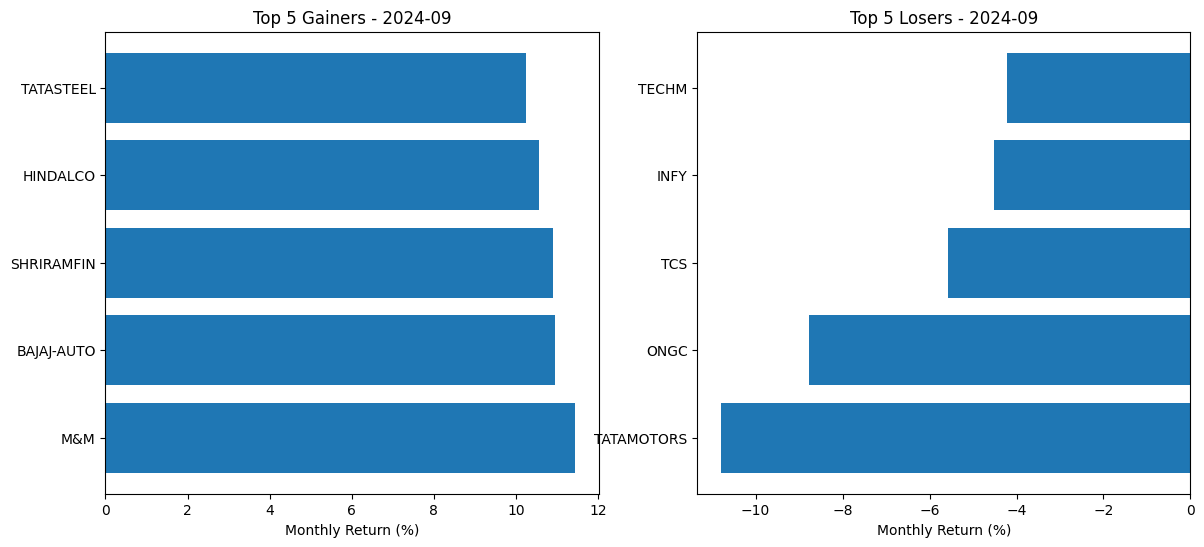

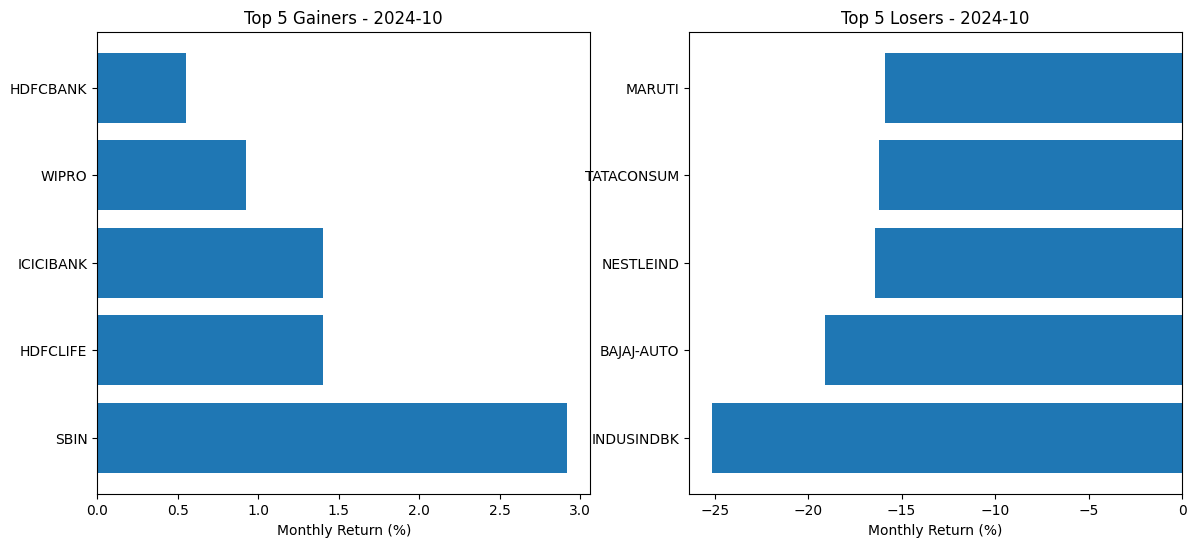

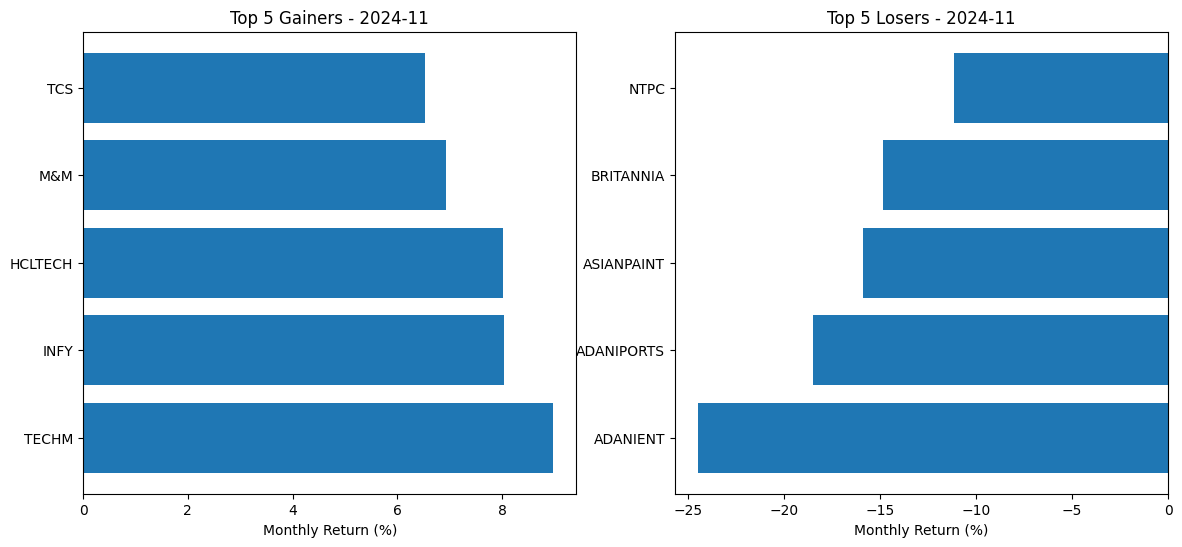

In [23]:
all_data = []

# -------- READ & COMBINE CSVs --------
for file in all_files:
    ticker = os.path.splitext(os.path.basename(file))[0].upper()
    df = pd.read_csv(file)

    if 'date' not in df.columns or 'close' not in df.columns:
        continue

    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['Ticker'] = ticker
    all_data.append(df)

combined_df = pd.concat(all_data, ignore_index=True)

# -------- EXTRACT MONTH --------
combined_df['Month'] = combined_df['date'].dt.to_period('M').astype(str)

# -------- MONTHLY RETURNS --------
monthly = (
    combined_df
    .sort_values('date')
    .groupby(['Ticker', 'Month'])['close']
    .agg(first='first', last='last')
    .reset_index()        # ✅ VERY IMPORTANT
)

monthly['Monthly_Return'] = (
    (monthly['last'] - monthly['first']) / monthly['first']
) * 100

# -------- UNIQUE MONTHS --------
unique_months = sorted(monthly['Month'].unique())

# -------- PLOTS --------
for month in unique_months:
    df_month = monthly[monthly['Month'] == month]
    top5_gainers = df_month.nlargest(5, 'Monthly_Return')
    top5_losers = df_month.nsmallest(5, 'Monthly_Return')

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Gainers
    axes[0].barh(top5_gainers['Ticker'], top5_gainers['Monthly_Return'])
    axes[0].set_title(f"Top 5 Gainers - {month}")
    axes[0].set_xlabel("Monthly Return (%)")

    # Losers
    axes[1].barh(top5_losers['Ticker'], top5_losers['Monthly_Return'])
    axes[1].set_title(f"Top 5 Losers - {month}")
    axes[1].set_xlabel("Monthly Return (%)")



In [22]:
monthly

,Ticker,Month,first,last,Monthly_Return
0,ADANIENT,2023-10,2387.25,2294.65,-3.878940
1,ADANIENT,2023-11,2217.30,2358.55,6.370360
2,ADANIENT,2023-12,2362.70,2848.95,20.580268
3,ADANIENT,2024-01,2917.20,3142.00,7.706019
4,ADANIENT,2024-02,3153.50,3285.40,4.182654
...,...,...,...,...,...
695,WIPRO,2024-07,527.35,522.00,-1.014506
696,WIPRO,2024-08,521.55,538.40,3.230754
697,WIPRO,2024-09,532.45,541.45,1.690300
698,WIPRO,2024-10,546.75,551.80,0.923640


In [19]:
df_month

,Ticker,Month,first,last,Monthly_Return
13,ADANIENT,2024-11,2949.50,2228.00,-24.461773
27,ADANIPORTS,2024-11,1394.40,1136.75,-18.477481
41,APOLLOHOSP,2024-11,7031.95,6935.10,-1.377285
55,ASIANPAINT,2024-11,2939.85,2472.20,-15.907274
69,AXISBANK,2024-11,1169.55,1142.40,-2.321406
83,BAJAJ-AUTO,2024-11,9875.95,9481.65,-3.992527
97,BAJAJFINSV,2024-11,1754.70,1600.85,-8.767881
111,BAJFINANCE,2024-11,6923.60,6683.95,-3.461350
125,BEL,2024-11,288.65,280.85,-2.702235
139,BHARTIARTL,2024-11,1616.45,1569.30,-2.916886
